In [1]:
import os
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /content


In [2]:
!pip install -q 'git+https://github.com/facebookresearch/segment-anything.git'

  Preparing metadata (setup.py) ... done


In [3]:
# download sam weights
!mkdir -p {HOME}/weights
!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth -P {HOME}/weights

In [4]:
import os

CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")
print(CHECKPOINT_PATH, "; exist:", os.path.isfile(CHECKPOINT_PATH))

/content/weights/sam_vit_h_4b8939.pth ; exist: True


In [5]:
#load model
import torch

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"

In [6]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)


 To run automatic mask generation, providing a SAM model to the SamAutomaticMaskGenerator class

In [7]:
mask_generator = SamAutomaticMaskGenerator(sam)


In [8]:
import os

IMAGE_NAME = "/content/template/screenshot_2024-05-02_17-22-50.jpg"
IMAGE_PATH = os.path.join(HOME, "data", IMAGE_NAME)

In [9]:
!pip install supervision
import cv2
import supervision as sv

image_bgr = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

sam_result = mask_generator.generate(image_rgb)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.0/111.0 kB 3.5 MB/s eta 0:00:00


visualization using sv

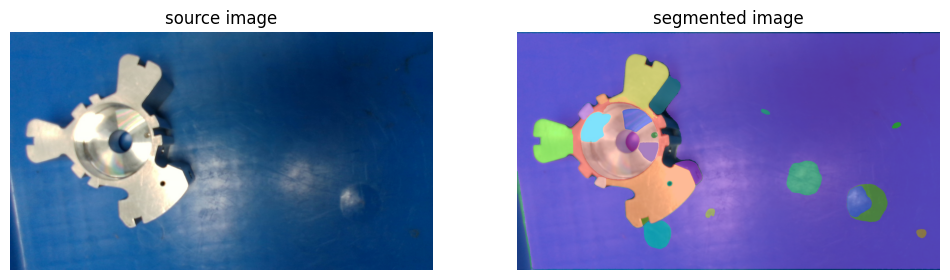

In [10]:
mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)

detections = sv.Detections.from_sam(sam_result=sam_result)

annotated_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[image_bgr, annotated_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

Generate Segmentation with Bounding Box

The SamPredictor class provides an easy interface to the model for prompting the model. Then, prompts can be provided via the predict method to efficiently predict masks from those prompts. The model can take as input both point and box prompts.

In [11]:
mask_predictor = SamPredictor(sam)

In [12]:
import os

IMAGE_NAME = "/content/test/screenshot_2024-05-02_17-23-09.jpg"
IMAGE_PATH = os.path.join(HOME, "data", IMAGE_NAME)

In [13]:
# helper function that loads an image before adding it to the widget

import base64

def encode_image(filepath):
    with open(filepath, 'rb') as f:
        image_bytes = f.read()
    encoded = str(base64.b64encode(image_bytes), 'utf-8')
    return "data:image/jpg;base64,"+encoded

In [ ]:
!pip install jupyter_bbox_widget

In [21]:
IS_COLAB = True

if IS_COLAB:
    from google.colab import output
    output.enable_custom_widget_manager()

from jupyter_bbox_widget import BBoxWidget

widget = BBoxWidget()
widget.image = encode_image(IMAGE_PATH)
widget

BBoxWidget(colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#b…

In [22]:
widget.bboxes

[{'x': 475, 'y': 346, 'width': 912, 'height': 734, 'label': ''}]

Generate masks with SAM
SamPredictor.predict method takes np.ndarray box argument in [x_min, y_min, x_max, y_max] format

In [23]:
import numpy as np

# default_box is going to be used if you will not draw any box on image above
default_box = {'x': 68, 'y': 247, 'width': 555, 'height': 678, 'label': ''}

box = widget.bboxes[0] if widget.bboxes else default_box
box = np.array([
    box['x'],
    box['y'],
    box['x'] + box['width'],
    box['y'] + box['height']
])

In [24]:
import cv2
import numpy as np
import supervision as sv

image_bgr = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

mask_predictor.set_image(image_rgb)

masks, scores, logits = mask_predictor.predict(
    box=box,
    multimask_output=True
)

SupervisionWarnings: red is deprecated: `Color.red()` is deprecated and will be removed in `supervision-0.22.0`. Use `Color.RED` instead.
SupervisionWarnings: red is deprecated: `Color.red()` is deprecated and will be removed in `supervision-0.22.0`. Use `Color.RED` instead.
SupervisionWarnings: annotate is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


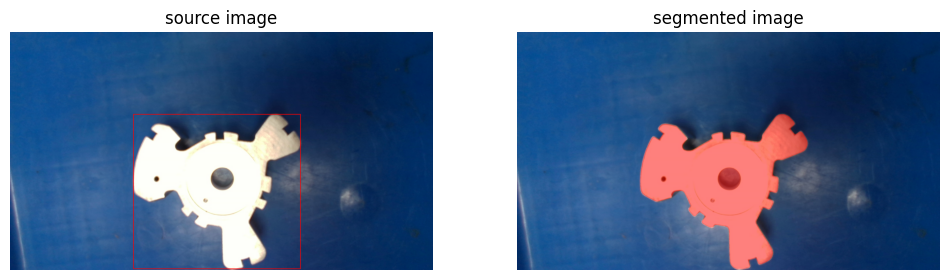

In [25]:
box_annotator = sv.BoxAnnotator(color=sv.Color.red())
mask_annotator = sv.MaskAnnotator(color=sv.Color.red(), color_lookup=sv.ColorLookup.INDEX)

detections = sv.Detections(
    xyxy=sv.mask_to_xyxy(masks=masks),
    mask=masks
)
detections = detections[detections.area == np.max(detections.area)]

source_image = box_annotator.annotate(scene=image_bgr.copy(), detections=detections, skip_label=True)
segmented_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[source_image, segmented_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

In [27]:


import os
import cv2
import numpy as np
import base64
from google.colab import output
from jupyter_bbox_widget import BBoxWidget
from google.colab.patches import cv2_imshow
import supervision as sv

# Function to encode image to base64
def encode_image(filepath):
    with open(filepath, 'rb') as f:
        image_bytes = f.read()
    encoded = str(base64.b64encode(image_bytes), 'utf-8')
    return "data:image/jpg;base64," + encoded

import os

IMAGE_NAME = "/content/test/screenshot_2024-05-02_17-23-09.jpg"
IMAGE_PATH = os.path.join(HOME, "data", IMAGE_NAME)

# Load the image and set up bounding box widget
widget = BBoxWidget()
widget.image = encode_image(IMAGE_PATH)
widget


BBoxWidget(colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#b…

SupervisionWarnings: annotate is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


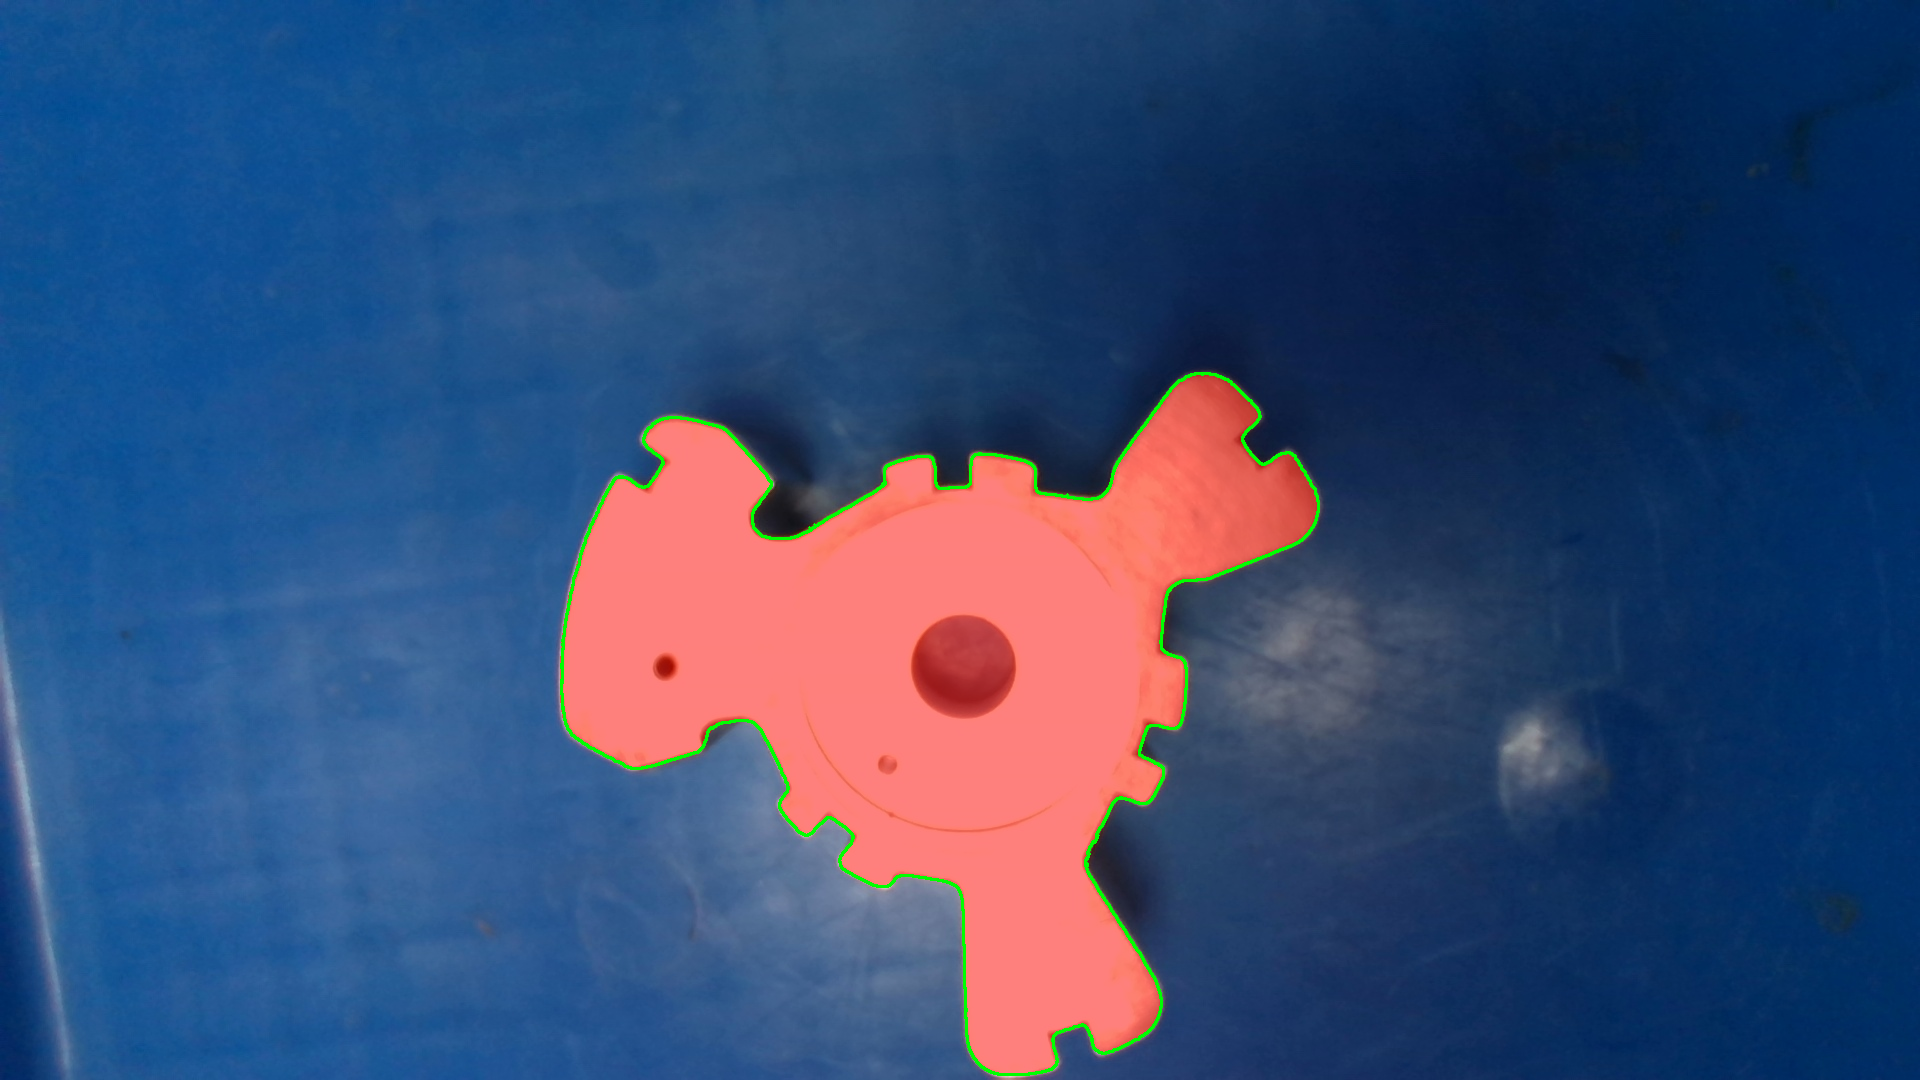

In [28]:
# Get bounding box coordinates
default_box = {'x': 68, 'y': 247, 'width': 555, 'height': 678, 'label': ''}
box = widget.bboxes[0] if widget.bboxes else default_box
box = np.array([
    box['x'],
    box['y'],
    box['x'] + box['width'],
    box['y'] + box['height']
])

# Load the image for segmentation
image_bgr = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

# Perform segmentation
mask_predictor.set_image(image_rgb)
masks, scores, logits = mask_predictor.predict(box=box, multimask_output=True)

# Select the largest mask
detections = sv.Detections(
    xyxy=sv.mask_to_xyxy(masks=masks),
    mask=masks
)
detections = detections[detections.area == np.max(detections.area)]

# Annotate the segmented image
source_image = box_annotator.annotate(scene=image_bgr.copy(), detections=detections, skip_label=True)
segmented_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

# Convert segmented image to HSV color space
hsv_segmented_image = cv2.cvtColor(segmented_image, cv2.COLOR_BGR2HSV)

# Define lower and upper thresholds for red color in HSV space
lower_red = np.array([0, 100, 100])
upper_red = np.array([10, 255, 255])

# Create a binary mask for pixels within the defined red color range
red_mask = cv2.inRange(hsv_segmented_image, lower_red, upper_red)

# Find contours in the binary mask
contours, _ = cv2.findContours(red_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

# Draw contours directly on the segmented image
cv2.drawContours(segmented_image, contours, -1, (0, 255, 0), 2)  # Green color, thickness = 2

# Display the segmented image with contours
cv2_imshow(segmented_image)
cv2.waitKey(0)
cv2.destroyAllWindows()

Now we start with a template image

In [29]:


import os
import cv2
import numpy as np
import base64
from google.colab import output
from jupyter_bbox_widget import BBoxWidget
from google.colab.patches import cv2_imshow
import supervision as sv

# Function to encode image to base64
def encode_image(filepath):
    with open(filepath, 'rb') as f:
        image_bytes = f.read()
    encoded = str(base64.b64encode(image_bytes), 'utf-8')
    return "data:image/jpg;base64," + encoded

import os

IMAGE_NAME = "/content/template/screenshot_2024-05-02_17-22-50.jpg"
IMAGE_PATH = os.path.join(HOME, "data", IMAGE_NAME)

# Load the image and set up bounding box widget
widget = BBoxWidget()
widget.image = encode_image(IMAGE_PATH)
widget


BBoxWidget(colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#b…

SupervisionWarnings: annotate is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


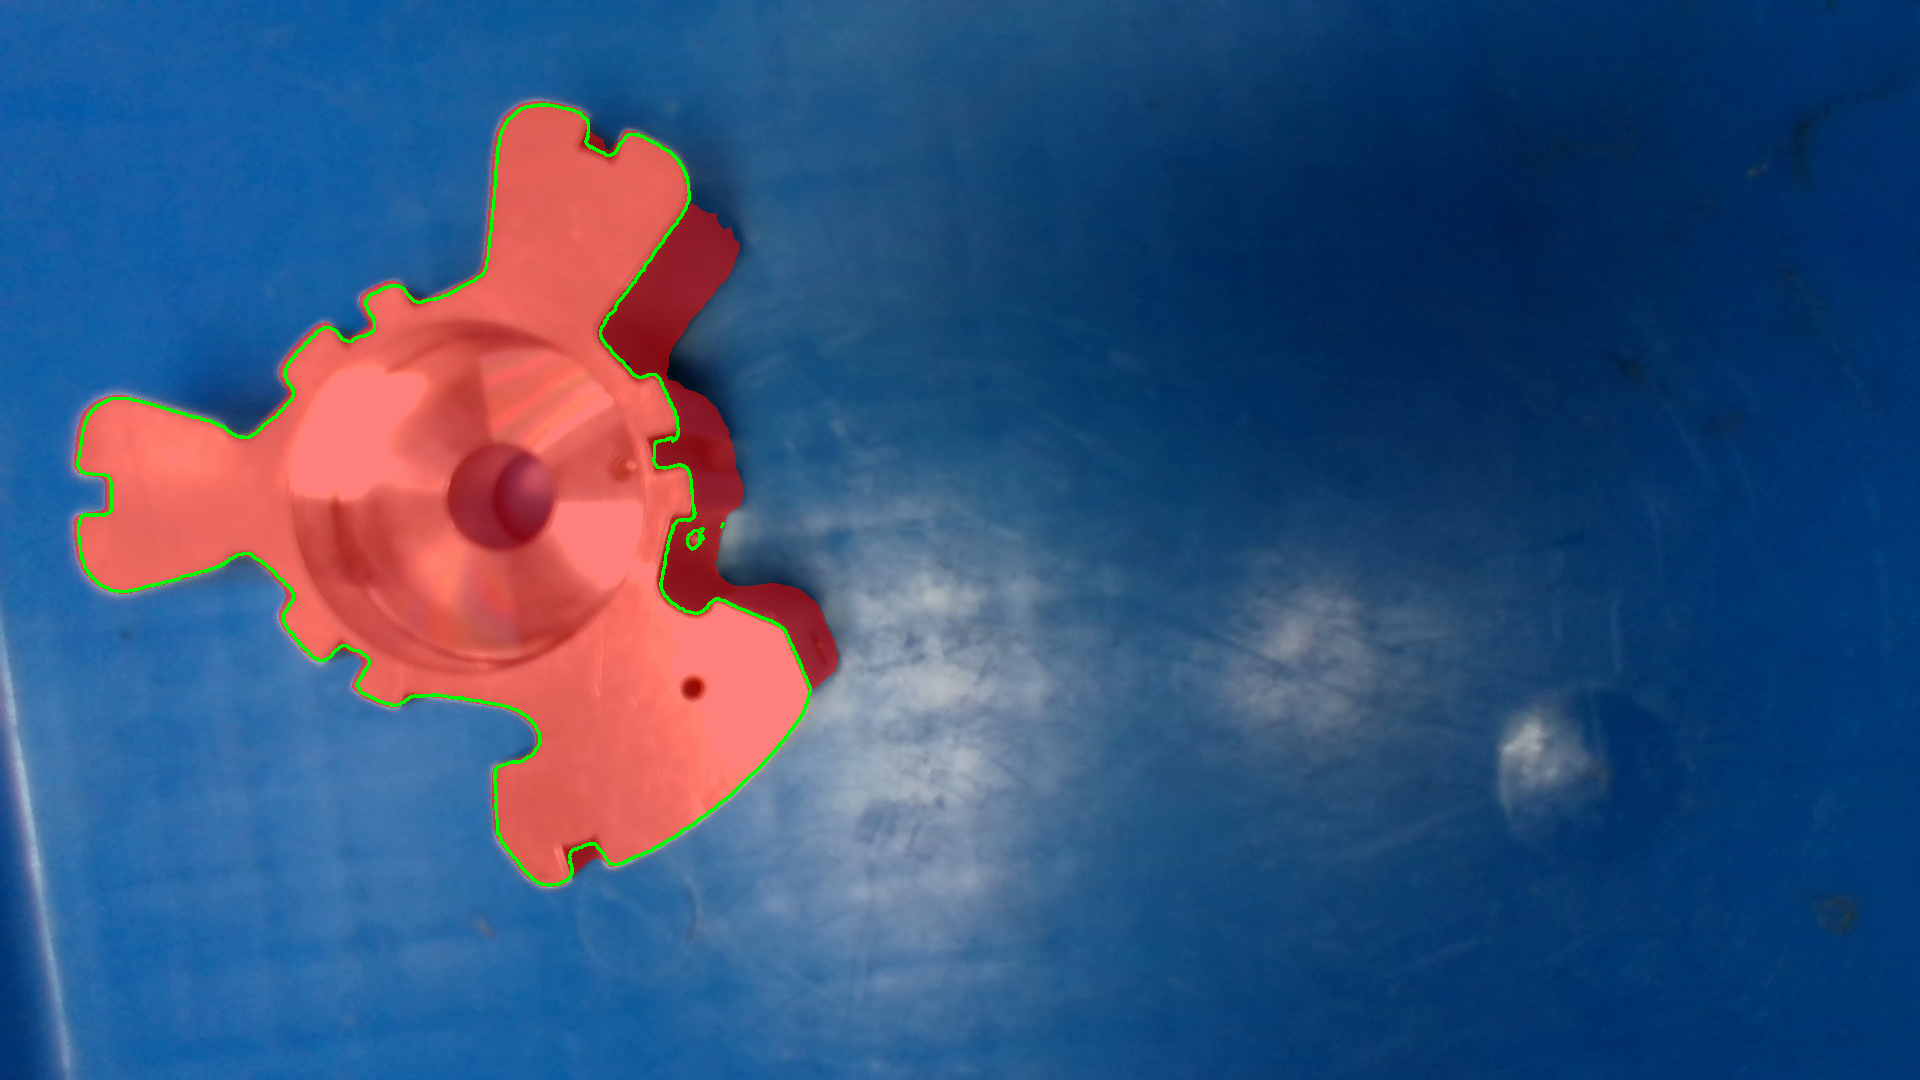

In [30]:
# Get bounding box coordinates
default_box = {'x': 68, 'y': 247, 'width': 555, 'height': 678, 'label': ''}
box = widget.bboxes[0] if widget.bboxes else default_box
box = np.array([
    box['x'],
    box['y'],
    box['x'] + box['width'],
    box['y'] + box['height']
])

# Load the image for segmentation
image_bgr = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

# Perform segmentation
mask_predictor.set_image(image_rgb)
masks, scores, logits = mask_predictor.predict(box=box, multimask_output=True)

# Select the largest mask
detections = sv.Detections(
    xyxy=sv.mask_to_xyxy(masks=masks),
    mask=masks
)
detections = detections[detections.area == np.max(detections.area)]

# Annotate the segmented image
source_image = box_annotator.annotate(scene=image_bgr.copy(), detections=detections, skip_label=True)
segmented_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

# Convert segmented image to HSV color space
hsv_segmented_image = cv2.cvtColor(segmented_image, cv2.COLOR_BGR2HSV)

# Define lower and upper thresholds for red color in HSV space
lower_red = np.array([0, 100, 100])
upper_red = np.array([10, 255, 255])

# Create a binary mask for pixels within the defined red color range
red_mask = cv2.inRange(hsv_segmented_image, lower_red, upper_red)

# Find contours in the binary mask
contours, _ = cv2.findContours(red_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

# Draw contours directly on the segmented image
cv2.drawContours(segmented_image, contours, -1, (0, 255, 0), 2)  # Green color, thickness = 2

# Display the segmented image with contours
cv2_imshow(segmented_image)
cv2.waitKey(0)
cv2.destroyAllWindows()

Contours are absolutely perfect

In [33]:
# Path to the second image
IMAGE_NAME_TEST = "/content/test/screenshot_2024-05-02_17-23-31.jpg"
IMAGE_PATH_TEST = os.path.join(HOME, "data", IMAGE_NAME_TEST)

# Load the second image and set up bounding box widget
widget_test = BBoxWidget()
widget_test.image = encode_image(IMAGE_PATH_TEST)
widget_test

BBoxWidget(colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#b…

SupervisionWarnings: annotate is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


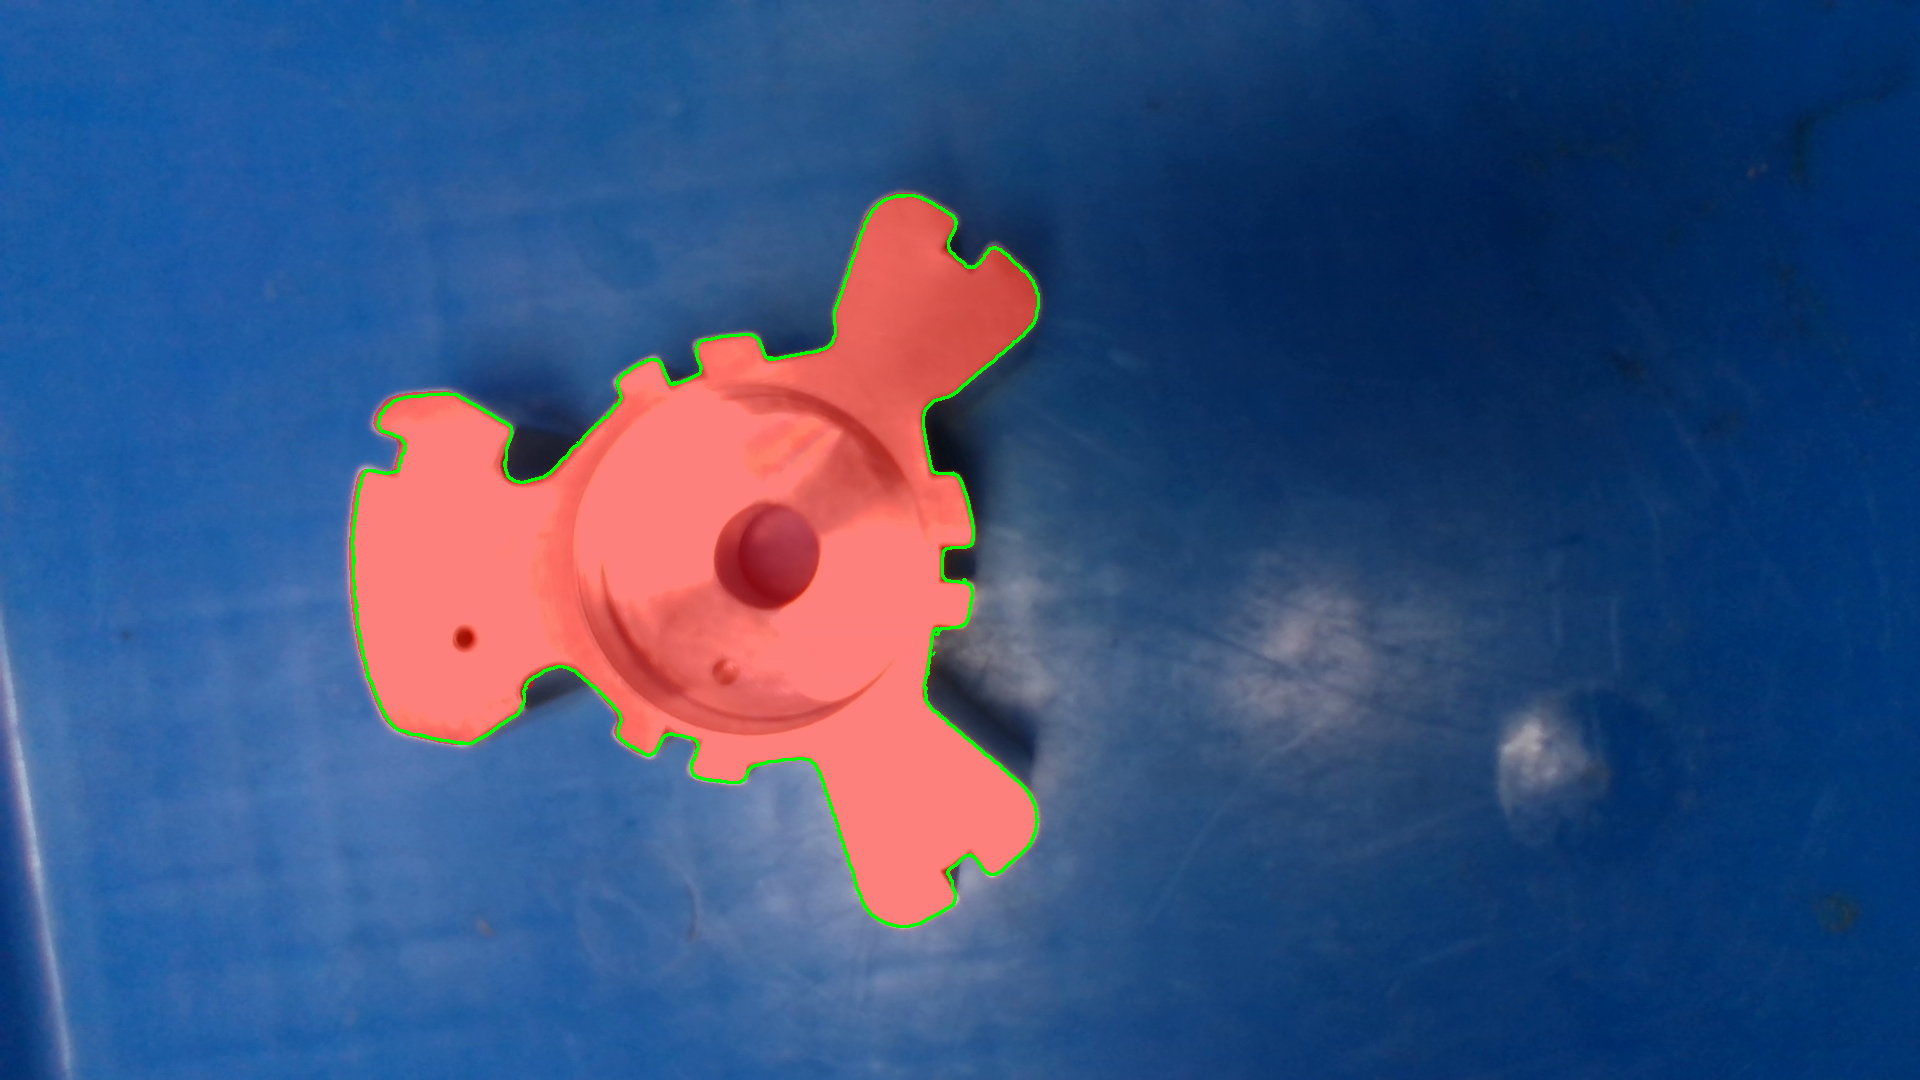

8

In [34]:
# Get bounding box coordinates for the second image
default_box_test = {'x': 68, 'y': 247, 'width': 555, 'height': 678, 'label': ''}
# default bounding box if nothing selected
box_test = widget_test.bboxes[0] if widget_test.bboxes else default_box_test
box_test = np.array([
    box_test['x'],
    box_test['y'],
    box_test['x'] + box_test['width'],
    box_test['y'] + box_test['height']
])

# Load the second image for segmentation
image_bgr_test = cv2.imread(IMAGE_PATH_TEST)
image_rgb_test = cv2.cvtColor(image_bgr_test, cv2.COLOR_BGR2RGB)

# Perform segmentation
mask_predictor.set_image(image_rgb_test)
masks_test, scores_test, logits_test = mask_predictor.predict(box=box_test, multimask_output=True)

# Select the largest mask
detections_test = sv.Detections(
    xyxy=sv.mask_to_xyxy(masks=masks_test),
    mask=masks_test
)
detections_test = detections_test[detections_test.area == np.max(detections_test.area)]

# Annotate the segmented image for the second image
source_image_test = box_annotator.annotate(scene=image_bgr_test.copy(), detections=detections_test, skip_label=True)
segmented_image_test = mask_annotator.annotate(scene=image_bgr_test.copy(), detections=detections_test)

# Convert segmented image to HSV color space
hsv_segmented_image_test = cv2.cvtColor(segmented_image_test, cv2.COLOR_BGR2HSV)

# Define lower and upper thresholds for red color in HSV space
lower_red_test = np.array([0, 100, 100])
upper_red_test = np.array([10, 255, 255])

# Create a binary mask for pixels within the defined red color range
red_mask_test = cv2.inRange(hsv_segmented_image_test, lower_red_test, upper_red_test)

# Find contours in the binary mask
contours_test, _ = cv2.findContours(red_mask_test, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

# Draw contours directly on the segmented image
cv2.drawContours(segmented_image_test, contours_test, -1, (0, 255, 0), 2)  # Green color, thickness = 2

# Display the segmented image with contours
cv2_imshow(segmented_image_test)
cv2.waitKey(0)
cv2.destroyAllWindows()

len(contours)